In [6]:
import pandas as pd
import psycopg2
import psycopg2.extras as extras
import matplotlib.pyplot as plt

# Make a class for connection and select query to PSQL using psycopg2

In [7]:
class MyDB():
    def koneksi(self, host, db, user, pw, port):
            self.conn = psycopg2.connect(host=host, database=db, user=user, password=pw, port=port )
            self.cur = self.conn.cursor()
        
            print('DB CONNECTED')
            print(self.conn.get_dsn_parameters())

    def queryselect(self, query):
            try:
                cols=[]
                self.cur.execute(query)
                self.conn.commit()
                data=self.cur.fetchall()
                print(self.cur.description[0])
                print(self.cur.description[1])
                #print(data)
                for elt in self.cur.description:
                    cols.append(elt[0])
                print(cols)
                df=pd.DataFrame(data=data, columns=cols)

                print('oke')
                return df
            except Exception as err:
                print('Error', err)                

    def close(self):
            self.cur.close()
            self.conn.close()

In [9]:
Database=MyDB()
Koneksi=Database.koneksi('192.168.133.54','DVDRental','postgres','polines2015','5432')

DB CONNECTED
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'DVDRental', 'host': '192.168.133.54', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'}


In [10]:
DataDF=Database.queryselect("""select concat(c.first_name,' ',c.last_name) as full_name, a.address, city.city, c3.country, 
f.title, f.rental_duration, c2.name, r.rental_date, p.payment_date from payment p left join customer c on p.customer_id = c.customer_id left join address a on c.address_id =a.address_id left join city on a.city_id = city.city_id left join rental r on p.rental_id =r.rental_id left join inventory i on r.inventory_id =i.inventory_id left join film f on i.film_id =f.film_id left join film_category fc on f.film_id =fc.film_id left join category c2 on fc.category_id =c2.category_id left join country c3 on city.country_id =c3.country_id where p.payment_date < now() order by payment_date ; """)

Column(name='full_name', type_code=25)
Column(name='address', type_code=1043)
['full_name', 'address', 'city', 'country', 'title', 'rental_duration', 'name', 'rental_date', 'payment_date']
oke


In [11]:
DataDF

,full_name,address,city,country,title,rental_duration,name,rental_date,payment_date
0,Jeffery Pinson,966 Arecibo Loop,Dadu,Pakistan,Giant Troopers,5,Children,2020-12-14 22:53:33,2021-08-14 21:21:59.996577
1,Elmer Noe,1768 Udine Loop,Battambang,Cambodia,Wash Heavenly,7,Foreign,2020-12-14 22:55:13,2021-08-14 21:23:39.996577
2,Minnie Romero,47 Syktyvkar Lane,Ciomas,Indonesia,Name Detective,5,Games,2020-12-14 23:00:34,2021-08-14 21:29:00.996577
3,Terrance Roush,42 Fontana Avenue,Szkesfehrvr,Hungary,Truman Crazy,7,Action,2020-12-14 23:12:46,2021-08-14 21:41:12.996577
4,Joyce Edwards,725 Isesaki Place,Jedda,Saudi Arabia,Sleuth Orient,4,Games,2020-12-14 23:16:26,2021-08-14 21:44:52.996577
...,...,...,...,...,...,...,...,...,...
14409,Clyde Tobias,1909 Dayton Avenue,Shaoguan,China,Lock Rear,7,Travel,2021-01-31 01:18:53,2021-10-30 23:47:19.996577
14410,Daniel Cabral,543 Bergamo Avenue,Ibirit,Brazil,Married Go,7,Sci-Fi,2021-01-31 01:19:02,2021-10-30 23:47:28.996577
14411,Shane Millard,184 Mandaluyong Street,La Paz,Mexico,Caper Motions,6,Comedy,2021-01-31 01:23:00,2021-10-30 23:51:26.996577
14412,Arnold Havens,1176 Southend-on-Sea Manor,Santa Rosa,Philippines,Family Sweet,4,Horror,2021-02-01 01:23:15,2021-10-30 23:51:41.996577


# Check null or drop
with DataDF.dropna(how='any').shape

In [6]:
DataDF.isnull().sum()

full_name          0
address            0
city               0
country            0
title              0
rental_duration    0
name               0
rental_date        0
payment_date       0
dtype: int64

# Count by country most rent

In [12]:
# DataDataDF.groupby(DataDF['country']).count()
#DataDF.head(5)
#DataDF.sort_values(['country'], ascending=True)
# DataDF[DataDF['country']=='Afghanistan']
CountByCountry=DataDF.groupby(DataDF['country']).size().reset_index(name='counts').sort_values(['counts'], ascending=False).head(5)
CountByCountry

,country,counts
42,India,1399
21,China,1284
101,United States,858
48,Japan,740
58,Mexico,712


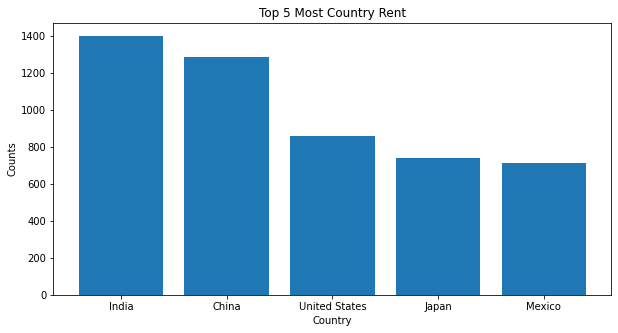

In [13]:
fig=plt.figure(figsize=(10,5))
plt.bar(CountByCountry['country'], CountByCountry['counts'])
plt.xlabel('Country')
plt.ylabel('Counts')
plt.title('Top 5 Most Country Rent')
plt.show()

In [14]:
DataDF.columns

Index(['full_name', 'address', 'city', 'country', 'title', 'rental_duration',
       'name', 'rental_date', 'payment_date'],
      dtype='object')

In [14]:
Database.close()

# Load to PSQL using **SQLAlchemi and String.IO**
### The io module provides Python’s main facilities for dealing with various types of I/O. There are three main types of I/O: text I/O, binary I/O and raw I/O. These are generic categories, and various backing stores can be used for each of them. A concrete object belonging to any of these categories is called a file object. Other common terms are stream and file-like object 
https://docs.python.org/3/library/io.html

In [15]:
from io import StringIO
from sqlalchemy import create_engine

In [16]:
username = 'postgres' # replace with your username
password = 'polines2015' # replace with your password
ipaddress = '192.168.133.54' # change this to your db’s IP address is if not Panoply
port = 5432 # this is the standard port for Postgres, but change it to your port if needed
dbname = 'DVDRental' # change this to...you guessed it...the name of your db


# A long string that contains the necessary Postgres login information
postgres_str = f'postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
          
# Create the connection
cnx = create_engine(postgres_str)

In [19]:
#DataDF.head(0)
DataDF.head(0).to_sql('my_cool_table', con=cnx, index=False)

In [21]:
raw_con = cnx.raw_connection() # assuming you set up cnx as above
cur  = raw_con.cursor()
out = StringIO()

DataDF.to_csv(out, sep='\t', header=False, index=False) 

out.seek(0) # sets the pointer on the file object to the first line
contents = out.getvalue()
cur.copy_from(out, 'my_cool_table', null="") # copies the contents of the file object into the SQL cursor and sets null values to empty strings
raw_con.commit()

In [ ]:
def execute_values(conn, df, table):
    """
    Using psycopg2.extras.execute_values() to insert the dataframe
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    query  = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_values() done")
    cursor.close()